# Capstone Part 2b - Classical ML Models (MFCCs without Offset)
___
## Setup

In [1]:
# Basic packages
import numpy as np
import pandas as pd

# For splitting the data into training and test sets
from sklearn.model_selection import train_test_split

# For scaling the data as necessary
from sklearn.preprocessing import StandardScaler

# For doing principal component analysis as necessary
from sklearn.decomposition import PCA

# For visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For logistic regression and SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# For hyperparameter optimization
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# For caching pipeline and grid search results
from tempfile import mkdtemp

# For model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For getting rid of warning messages
import warnings
warnings.filterwarnings('ignore')

# For pickling models
import joblib

# Loading in the finished dataframe from part 1
ravdess_mfcc_no_offset_df = pd.read_csv('C:/Users/Patrick/Documents/Capstone Data/ravdess_mfcc_no_offset.csv')

In [2]:
ravdess_mfcc_no_offset_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2592,2593,2594,2595,2596,2597,2598,2599,Gender,Emotion
0,-857.309453,-857.309453,-857.309453,-857.309453,-857.309453,-857.309453,-857.309453,-857.165711,-857.309453,-857.309453,...,1.546741,1.982412,2.188718,2.742868,0.987672,1.042513,1.416731,0.817693,male,neutral
1,-864.890286,-864.890286,-864.890286,-864.890286,-861.939471,-860.492254,-863.877686,-862.146948,-860.825373,-862.288360,...,0.760483,0.900741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male,neutral
2,-849.445433,-848.003746,-844.977418,-848.275738,-847.952191,-847.026382,-849.022875,-848.187830,-851.179822,-852.391785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.056836,0.000000,0.000000,male,neutral
3,-832.734397,-836.552680,-834.580541,-827.005858,-830.058798,-831.195983,-839.331695,-838.307510,-834.128916,-839.040966,...,0.098864,0.972775,1.156853,1.185786,0.808819,0.931570,0.595077,-0.121792,male,neutral
4,-902.406412,-896.903279,-893.962205,-900.335460,-902.472509,-902.626385,-905.461199,-905.147436,-905.978456,-904.582022,...,-2.037989,1.646397,2.192631,0.140728,3.285294,0.473829,0.745187,1.507095,male,calm


___
# Building Models for Classifying Gender (Regardless of Emotion)

In [3]:
# Splitting the dataframe into features and target
X = ravdess_mfcc_no_offset_df.iloc[:, :-2]
g = ravdess_mfcc_no_offset_df['Gender']

The convention is to name the target variable 'y', but I will be declaring many different target variables throughout the notebook, so I opted for 'g' for simplicity instead of 'y_g' or 'y_gen', for example.

In [4]:
# Splitting the data into training and test sets
X_train, X_test, g_train, g_test = train_test_split(X, g, test_size=0.3, stratify=g, random_state=1)

In [5]:
# Checking the shapes
print(X_train.shape)
print(X_test.shape)
print(g_train.shape)
print(g_test.shape)

(1006, 2600)
(432, 2600)
(1006,)
(432,)


I want to build a simple, initial classifier to get a sense of the performances I might get in more optimized models. To this end, I will build a logistic regression model without doing any cross-validation or hyperparameter optimization.

In [6]:
# Instantiate the model
initial_logreg = LogisticRegression()

# Fit to training set
initial_logreg.fit(X_train, g_train)

# Score on training set
print(f'Model accuracy on training set: {initial_logreg.score(X_train, g_train)*100}%')

# Score on test set
print(f'Model accuracy on test set: {initial_logreg.score(X_test, g_test)*100}%')

Model accuracy on training set: 100.0%
Model accuracy on test set: 99.53703703703704%


These are extremely high accuracies. The model has most likely overfit to the training set, but the accuracy on the test set is still surprisingly high.

Here are some possible explanations:
- The dataset (RAVDESS) is relatively small, with only 1440 data points (1438 if I do not count the two very short clips that I excluded). This model is likely not very robust and has easily overfit to the training set.
- The features I have extracted could be excellent predictors of gender.
- This could be a very simple classification task. After all, there are only two classes, and theoretically, features extracted from male and female voice clips should have distinguishable patterns.

I had originally planned to build more gender classification models for this dataset, but I will forgo this for now. In part 4, I will try using this model to classify clips from another dataset and examine its performance.

In [64]:
# Pickling the model for later use
joblib.dump(initial_logreg, 'pickle1_gender_logreg.pkl') 

['pickle1_gender_logreg.pkl']

___
# Building Models for Classifying Emotion for Males

In [2]:
# Making a new dataframe that contains only male recordings
male_df = ravdess_mfcc_no_offset_df[ravdess_mfcc_no_offset_df['Gender'] == 'male'].reset_index().drop('index', axis=1)
male_df

,0,1,2,3,4,5,6,7,8,9,...,2592,2593,2594,2595,2596,2597,2598,2599,Gender,Emotion
0,-857.309453,-857.309453,-857.309453,-857.309453,-857.309453,-857.309453,-857.309453,-857.165711,-857.309453,-857.309453,...,1.546741,1.982412,2.188718,2.742868,0.987672,1.042513,1.416731,0.817693,male,neutral
1,-864.890286,-864.890286,-864.890286,-864.890286,-861.939471,-860.492254,-863.877686,-862.146948,-860.825373,-862.288360,...,0.760483,0.900741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male,neutral
2,-849.445433,-848.003746,-844.977418,-848.275738,-847.952191,-847.026382,-849.022875,-848.187830,-851.179822,-852.391785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.056836,0.000000,0.000000,male,neutral
3,-832.734397,-836.552680,-834.580541,-827.005858,-830.058798,-831.195983,-839.331695,-838.307510,-834.128916,-839.040966,...,0.098864,0.972775,1.156853,1.185786,0.808819,0.931570,0.595077,-0.121792,male,neutral
4,-902.406412,-896.903279,-893.962205,-900.335460,-902.472509,-902.626385,-905.461199,-905.147436,-905.978456,-904.582022,...,-2.037989,1.646397,2.192631,0.140728,3.285294,0.473829,0.745187,1.507095,male,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,-704.004406,-703.014570,-702.031038,-703.328468,-703.912309,-703.765455,-704.655862,-704.481680,-703.788671,-702.783204,...,0.000000,0.000000,0.000000,0.000000,0.045276,0.192656,0.852603,0.690963,male,surprised
714,-693.614951,-693.114727,-693.250694,-693.924253,-693.967910,-693.131289,-692.858776,-693.739184,-694.119294,-694.119294,...,1.554530,1.873090,1.168382,0.152251,0.392736,0.984920,0.792893,0.080783,male,surprised
715,-692.801891,-692.803866,-693.082432,-693.371465,-693.371465,-693.371465,-693.371465,-693.351801,-692.287004,-692.734244,...,0.668347,0.486409,0.601826,0.474456,0.194573,0.030500,0.000000,0.118997,male,surprised
716,-669.158136,-669.158136,-669.158136,-669.158136,-669.158136,-669.158136,-669.158136,-669.158136,-669.158136,-669.158136,...,0.375527,0.331931,0.036515,0.000000,0.000000,0.000000,0.000000,0.000000,male,surprised


In [3]:
# Splitting the dataframe into features and target
Xm = male_df.iloc[:, :-2]
em = male_df['Emotion']

In [4]:
# Splitting the data into training and test sets
Xm_train, Xm_test, em_train, em_test = train_test_split(Xm, em, test_size=0.3, stratify=em, random_state=1)

In [5]:
# Checking the shapes
print(Xm_train.shape)
print(Xm_test.shape)
print(em_train.shape)
print(em_test.shape)

(502, 2600)
(216, 2600)
(502,)
(216,)


As before, I will try building an initial model.

In [6]:
# Instantiate the model
initial_logreg_em = LogisticRegression()

# Fit to training set
initial_logreg_em.fit(Xm_train, em_train)

# Score on training set
print(f'Model accuracy on training set: {initial_logreg_em.score(Xm_train, em_train)*100}%')

# Score on test set
print(f'Model accuracy on test set: {initial_logreg_em.score(Xm_test, em_test)*100}%')

Model accuracy on training set: 100.0%
Model accuracy on test set: 59.72222222222222%


The model has overfit to the training set yet again, and this time the accuracy on the test set leaves a lot to be desired. Let's evaluate the model further using a confusion matrix and a classification report.

In [7]:
# Having initial_logreg_em make predictions based on the test set features
em_pred = initial_logreg_em.predict(Xm_test)

# Building the confusion matrix as a dataframe
emotions = ['angry', 'calm', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
em_confusion_df = pd.DataFrame(confusion_matrix(em_test, em_pred))
em_confusion_df.columns = [f'Predicted {emotion}' for emotion in emotions]
em_confusion_df.index = [f'Actual {emotion}' for emotion in emotions]
em_confusion_df

,Predicted angry,Predicted calm,Predicted disgusted,Predicted fearful,Predicted happy,Predicted neutral,Predicted sad,Predicted surprised
Actual angry,23,1,2,1,1,1,0,0
Actual calm,0,23,0,0,1,0,3,1
Actual disgusted,3,3,10,3,0,1,5,4
Actual fearful,2,1,1,20,1,0,2,2
Actual happy,4,1,3,2,15,2,1,1
Actual neutral,0,2,1,0,0,8,1,2
Actual sad,1,4,2,3,1,1,16,1
Actual surprised,2,1,4,1,3,1,3,14


In [8]:
# Classification report
print(classification_report(em_test, em_pred))

              precision    recall  f1-score   support

       angry       0.66      0.79      0.72        29
        calm       0.64      0.82      0.72        28
   disgusted       0.43      0.34      0.38        29
     fearful       0.67      0.69      0.68        29
       happy       0.68      0.52      0.59        29
     neutral       0.57      0.57      0.57        14
         sad       0.52      0.55      0.53        29
   surprised       0.56      0.48      0.52        29

    accuracy                           0.60       216
   macro avg       0.59      0.60      0.59       216
weighted avg       0.59      0.60      0.59       216



In a binary classification problem, there is one negative class and one positive class. This is not the case here, because this is a multiclass classification problem. In the table above, each row of precision and recall scores assumes the corresponding emotion is the positive class, and groups all other emotions as the negative class.

Precision is the following measure: Of all the data points that the model classified as belonging to the positive class (i.e., the true and false positives), what proportion is correct (i.e., truly positive)?

Recall is the following measure: Of all the data points that are truly positive (i.e., the true positives and false negatives as classified by the model), what proportion did the model correctly classify (i.e., the true positives)?

It appears that the initial model is strongest at classifying calm voice clips, and weakest at classifying disgusted voice clips. In order of strongest to weakest: calm, angry, fearful, happy, neutral, sad, surprised, and disgusted.

I will now try building new models and optimizing hyperparameters to obtain better performance. I will use a pipeline and multiple grid searches to accomplish this.

Before I build all my models in bulk, I want to see if doing principal component analysis (PCA) could be beneficial. I will do PCA on both unscaled and scaled features, and plot the resulting explained variance ratios. I have two goals here:
- Get a sense of whether scaling would be beneficial for model performance
- Get a sense of how many principal components I should use

In [14]:
# PCA on unscaled features

# Instantiate PCA and fit to Xm_train
pca = PCA().fit(Xm_train)

# Transform Xm_train
Xm_train_pca = pca.transform(Xm_train)

# Transform Xm_test
Xm_test_pca = pca.transform(Xm_test)

In [15]:
# Standard scaling

# Instantiate the scaler and fit to Xm_train
scaler = StandardScaler().fit(Xm_train)

# Transform Xm_train
Xm_train_scaled = scaler.transform(Xm_train)

# Transform Xm_test
Xm_test_scaled = scaler.transform(Xm_test)

In [16]:
# PCA on scaled features

# Instantiate PCA and fit to Xm_train_scaled
pca_scaled = PCA().fit(Xm_train_scaled)

# Transform Xm_train_scaled
Xm_train_scaled_pca = pca_scaled.transform(Xm_train_scaled)

# Transform Xm_test_scaled
Xm_test_scaled_pca = pca_scaled.transform(Xm_test_scaled)

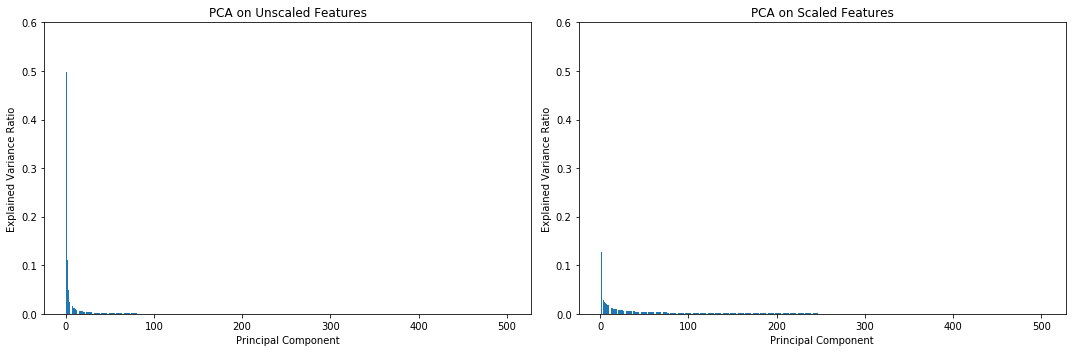

In [19]:
# Plot the explained variance ratios

plt.subplots(1, 2, figsize = (15, 5))

# Unscaled
plt.subplot(1, 2, 1)
plt.bar(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA on Unscaled Features')
plt.ylim(top = 0.6) # Equalizing the y-axes

# Scaled
plt.subplot(1, 2, 2)
plt.bar(np.arange(1, len(pca_scaled.explained_variance_ratio_)+1), pca_scaled.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA on Scaled Features')
plt.ylim(top = 0.6) # Equalizing the y-axes

plt.tight_layout()
plt.show()

Principal components are linear combinations of the original features, ordered by how much of the dataset's variance they explain. Looking at the two plots above, it appears that for the same number of principal components, those using unscaled features are able to explain more variance (i.e., capture more information) than those using scaled features. For example, looking at the first ~25 principal components of each plot, the bars of the left plot (unscaled) are higher and skewed more to the left than those of the right plot (scaled). Since the purpose of PCA is to reduce dimensionality of the data by keeping the components that explain the most variance and discarding the rest, the unscaled principal components might benefit my models more than the scaled principal components will.

However, I have to be mindful of the underlying variance in my features. Some features have values in the -800s, while others are close to 0.

In [21]:
# Examining the variances
var_df = pd.DataFrame(male_df.var()).T
var_df

,0,1,2,3,4,5,6,7,8,9,...,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599
0,12210.478339,12201.77418,12111.401191,12044.003287,12120.508756,12328.912595,12356.51745,12248.786453,12196.954637,12130.661598,...,49.516361,48.535437,47.306909,42.627579,42.790836,44.790109,45.562742,43.973544,35.034523,30.159845


Since PCA is looking for high variance directions, it can become biased by the underlying variance in a given feature if I do not scale it down first. I can see that some features have much higher variance than others do, so there is likely a lot of bias in the unscaled principal components above.

How much variance is explained by certain numbers of unscaled and scaled principal components? This will help me determine how many principal components to try in my grid searches later.

In [22]:
# Unscaled
num_components = [503, 451, 401, 351, 301, 251, 201, 151, 101, 51]
for n in num_components:
    print(f'Variance explained by {n-1} unscaled principal components: {np.round(np.sum(pca.explained_variance_ratio_[:n])*100, 2)}%')

Variance explained by 502 unscaled principal components: 100.0%
Variance explained by 450 unscaled principal components: 99.93%
Variance explained by 400 unscaled principal components: 99.82%
Variance explained by 350 unscaled principal components: 99.64%
Variance explained by 300 unscaled principal components: 99.38%
Variance explained by 250 unscaled principal components: 99.0%
Variance explained by 200 unscaled principal components: 98.43%
Variance explained by 150 unscaled principal components: 97.52%
Variance explained by 100 unscaled principal components: 95.91%
Variance explained by 50 unscaled principal components: 92.2%


In [23]:
# Scaled
num_components = [503, 451, 401, 351, 301, 251, 201, 151, 101, 51]
for n in num_components:
    print(f'Variance explained by {n-1} scaled principal components: {np.round(np.sum(pca_scaled.explained_variance_ratio_[:n])*100, 2)}%')

Variance explained by 502 scaled principal components: 100.0%
Variance explained by 450 scaled principal components: 99.5%
Variance explained by 400 scaled principal components: 98.66%
Variance explained by 350 scaled principal components: 97.42%
Variance explained by 300 scaled principal components: 95.65%
Variance explained by 250 scaled principal components: 93.12%
Variance explained by 200 scaled principal components: 89.55%
Variance explained by 150 scaled principal components: 84.34%
Variance explained by 100 scaled principal components: 76.42%
Variance explained by 50 scaled principal components: 62.92%


I will now build a pipeline and multiple grid searches with five-fold cross-validation to optimize the hyperparameters. I will try two types of classifiers: logistic regression and support vector machine. I have chosen these based on the fact that they performed better than other classifer types in part 2a. To get a better sense of how each type performs, I will make a grid search for each one. I will also try different numbers of principal components for unscaled and scaled features.

In [24]:
# Cache
cachedir = mkdtemp()

# Pipeline (these values are placeholders)
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

In [25]:
# Parameter grid for log reg
logreg_param_grid = [
    # l1 without PCA
    # unscaled and scaled * 9 regularization strengths = 18 models
    {'scaler': [None, StandardScaler()], 'dim_reducer': [None], 'model': [LogisticRegression(penalty='l1', n_jobs=-1)],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l1 unscaled with PCA
    # 5 PCAs * 9 regularization strengths = 45 models
    {'scaler': [None], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(50, 251, 50),
     'model': [LogisticRegression(penalty='l1', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l1 scaled with PCA
    # 4 PCAs * 9 regularization strengths = 36 models
    {'scaler': [StandardScaler()], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(200, 351, 50),
     'model': [LogisticRegression(penalty='l1', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l2 (default) without PCA
    # unscaled and scaled * 9 regularization strengths = 18 models
    {'scaler': [None, StandardScaler()], 'dim_reducer': [None], 'model': [LogisticRegression(solver='lbfgs', n_jobs=-1)],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l2 (default) unscaled with PCA
    # 5 PCAs * 9 regularization strengths = 45 models
    {'scaler': [None], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(50, 251, 50),
     'model': [LogisticRegression(solver='lbfgs', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l2 (default) scaled with PCA
    # 4 PCAs * 9 regularization strengths = 36 models
    {'scaler': [StandardScaler()], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(200, 351, 50),
     'model': [LogisticRegression(solver='lbfgs', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
]

# Instantiate the log reg grid search
logreg_grid_search = GridSearchCV(estimator=my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=5)

In [26]:
# Fit the log reg grid search
fitted_logreg_grid_em = logreg_grid_search.fit(Xm_train, em_train)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:  4.5min finished


In [27]:
# What was the best log reg?
fitted_logreg_grid_em.best_estimator_

Pipeline(memory='C:\\Users\\Patrick\\AppData\\Local\\Temp\\tmp9ppwr2jl',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=350,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [28]:
print(f"The best log reg's accuracy on the training set: {fitted_logreg_grid_em.score(Xm_train, em_train)*100}%")
print(f"The best log reg's accuracy on the test set: {fitted_logreg_grid_em.score(Xm_test, em_test)*100}%")

The best log reg's accuracy on the training set: 100.0%
The best log reg's accuracy on the test set: 61.57407407407407%


In [29]:
# Pickling the best log reg
joblib.dump(fitted_logreg_grid_em.best_estimator_, 'pickle2_male_emotion_logreg.pkl')

['pickle2_male_emotion_logreg.pkl']

In [30]:
# Parameter grid for SVM
svm_param_grid = [
    # unscaled and scaled * 9 regularization strengths = 18 models
    {'scaler': [None, StandardScaler()], 'dim_reducer': [None], 'model': [SVC()], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # unscaled
    # 5 PCAs * 9 regularization strengths = 45 models
    {'scaler': [None], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(50, 251, 50), 'model': [SVC()],
     'model__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # scaled
    # 4 PCAs * 9 regularization strengths = 36 models
    {'scaler': [StandardScaler()], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(200, 351, 50), 'model': [SVC()],
     'model__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
]

# Instantiate the SVM grid search
svm_grid_search = GridSearchCV(estimator=my_pipeline, param_grid=svm_param_grid, cv=5, n_jobs=-1, verbose=5)

In [31]:
# Fit the SVM grid search
fitted_svm_grid_em = svm_grid_search.fit(Xm_train, em_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  1.2min finished


In [32]:
# What was the best SVM?
fitted_svm_grid_em.best_estimator_

Pipeline(memory='C:\\Users\\Patrick\\AppData\\Local\\Temp\\tmp9ppwr2jl',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer', None),
                ('model',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [33]:
print(f"The best SVM's accuracy on the training set: {fitted_svm_grid_em.score(Xm_train, em_train)*100}%")
print(f"The best SVM's accuracy on the test set: {fitted_svm_grid_em.score(Xm_test, em_test)*100}%")

The best SVM's accuracy on the training set: 100.0%
The best SVM's accuracy on the test set: 66.20370370370371%


In [34]:
# Pickling the best SVM
joblib.dump(fitted_svm_grid_em.best_estimator_, 'pickle3_male_emotion_svm.pkl')

['pickle3_male_emotion_svm.pkl']

I will try loading in the pickled models and evaluate them using confusion matrices and classification reports.

In [9]:
# Loading in the best male emotion classifiers
male_emotion_logreg = joblib.load('pickle2_male_emotion_logreg.pkl')
male_emotion_svm = joblib.load('pickle3_male_emotion_svm.pkl')

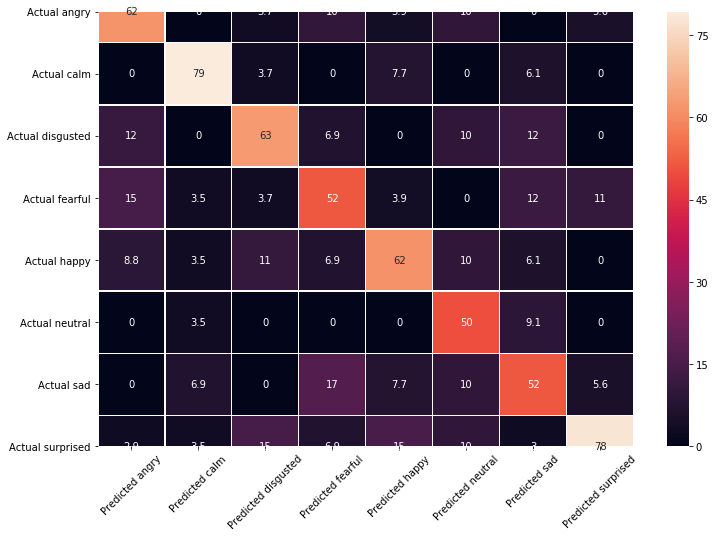

In [36]:
em_pred = male_emotion_logreg.predict(Xm_test)

# Building the confusion matrix as a dataframe
emotions = ['angry', 'calm', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
em_confusion_df = pd.DataFrame(confusion_matrix(em_test, em_pred))
em_confusion_df.columns = [f'Predicted {emotion}' for emotion in emotions]
em_confusion_df.index = [f'Actual {emotion}' for emotion in emotions]

# Converting the above to precision scores
em_confusion_df_pct = round(em_confusion_df/em_confusion_df.sum(axis = 0)*100, 2)

# Heatmap of precision scores
plt.figure(figsize=(12, 8))
sns.heatmap(em_confusion_df_pct, annot=True, linewidths=0.5)
plt.xticks(rotation=45)
plt.show()

In [37]:
# Classification report
print(classification_report(em_test, em_pred))

              precision    recall  f1-score   support

       angry       0.62      0.72      0.67        29
        calm       0.79      0.82      0.81        28
   disgusted       0.63      0.59      0.61        29
     fearful       0.52      0.52      0.52        29
       happy       0.62      0.55      0.58        29
     neutral       0.50      0.71      0.59        14
         sad       0.52      0.59      0.55        29
   surprised       0.78      0.48      0.60        29

    accuracy                           0.62       216
   macro avg       0.62      0.62      0.61       216
weighted avg       0.63      0.62      0.61       216



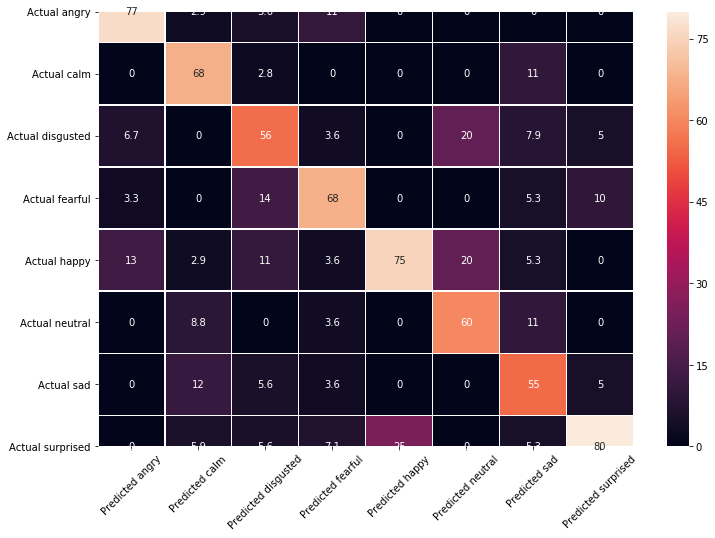

In [38]:
em_pred = male_emotion_svm.predict(Xm_test)

# Building the confusion matrix as a dataframe
emotions = ['angry', 'calm', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
em_confusion_df = pd.DataFrame(confusion_matrix(em_test, em_pred))
em_confusion_df.columns = [f'Predicted {emotion}' for emotion in emotions]
em_confusion_df.index = [f'Actual {emotion}' for emotion in emotions]

# Converting the above to precision scores
em_confusion_df_pct = round(em_confusion_df/em_confusion_df.sum(axis = 0)*100, 2)

# Heatmap of precision scores
plt.figure(figsize=(12, 8))
sns.heatmap(em_confusion_df_pct, annot=True, linewidths=0.5)
plt.xticks(rotation=45)
plt.show()

In [39]:
# Classification report
print(classification_report(em_test, em_pred))

              precision    recall  f1-score   support

       angry       0.77      0.79      0.78        29
        calm       0.68      0.82      0.74        28
   disgusted       0.56      0.69      0.62        29
     fearful       0.68      0.66      0.67        29
       happy       0.75      0.52      0.61        29
     neutral       0.60      0.43      0.50        14
         sad       0.55      0.72      0.63        29
   surprised       0.80      0.55      0.65        29

    accuracy                           0.66       216
   macro avg       0.67      0.65      0.65       216
weighted avg       0.68      0.66      0.66       216



___
# Building Models for Classifying Emotion for Females

In [41]:
# Making a new dataframe that contains only female recordings
female_df = ravdess_mfcc_no_offset_df[ravdess_mfcc_no_offset_df['Gender'] == 'female'].reset_index().drop('index', axis=1)
female_df

,0,1,2,3,4,5,6,7,8,9,...,2592,2593,2594,2595,2596,2597,2598,2599,Gender,Emotion
0,-828.424007,-828.424007,-828.424007,-828.424007,-828.424007,-828.424007,-828.424007,-828.424007,-828.424007,-828.424007,...,0.920487,1.142689,1.645541,0.662126,-2.959728,-2.974654,-3.218986,-1.575759,female,neutral
1,-816.246342,-816.246342,-816.246342,-816.246342,-816.246342,-816.246342,-816.246342,-816.246342,-816.246342,-816.246342,...,-0.228949,-0.707065,0.462528,-0.680065,-0.896755,0.134081,-2.220807,-5.561842,female,neutral
2,-801.998403,-801.998403,-801.998403,-801.998403,-801.998403,-801.998403,-801.998403,-801.998403,-801.998403,-801.998403,...,-3.942946,-2.129235,-2.910708,-1.609172,-3.229009,-3.320858,-1.769103,-4.660400,female,neutral
3,-815.740988,-815.366061,-816.948004,-818.018244,-818.377854,-818.377854,-818.377854,-818.377854,-818.377854,-818.377854,...,-1.303561,-0.976235,0.755248,-0.303678,-0.677214,-4.022101,-0.964241,-0.908779,female,neutral
4,-840.741626,-840.741626,-840.741626,-840.741626,-840.741626,-840.741626,-840.741626,-840.499265,-840.403957,-840.732397,...,-5.276046,-11.831193,-15.723968,-8.195305,-3.713976,-2.014079,-1.137595,-1.414328,female,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-764.912613,-764.912613,-764.912613,-764.912613,-764.912613,-764.912613,-764.912613,-764.912613,-764.912613,-764.912613,...,-0.896832,-0.392337,-0.061991,0.000000,0.000000,0.000000,0.000000,0.000000,female,surprised
716,-732.371448,-732.371448,-732.371448,-732.371448,-732.371448,-732.371448,-732.371448,-732.371448,-732.371448,-732.371448,...,14.521227,11.316990,8.713079,10.328533,9.036978,3.399172,0.749259,3.379535,female,surprised
717,-741.416134,-741.416134,-741.416134,-741.416134,-741.416134,-741.416134,-741.416134,-741.416134,-741.416134,-741.416134,...,33.032120,30.513006,16.692862,11.868344,12.438664,9.639763,11.089835,15.954101,female,surprised
718,-713.463556,-713.463556,-713.463556,-713.463556,-713.463556,-712.544956,-707.772996,-712.991454,-713.463556,-713.463556,...,1.778087,0.784658,2.449260,1.380714,0.030581,-1.293232,-1.480161,-1.456663,female,surprised


In [42]:
# Splitting the dataframe into features and target
Xf = female_df.iloc[:, :-2]
ef = female_df['Emotion']

In [43]:
# Splitting the data into training and test sets
Xf_train, Xf_test, ef_train, ef_test = train_test_split(Xf, ef, test_size=0.3, stratify=ef, random_state=1)

In [44]:
# Checking the shapes
print(Xf_train.shape)
print(Xf_test.shape)
print(ef_train.shape)
print(ef_test.shape)

(504, 2600)
(216, 2600)
(504,)
(216,)


Here is an initial model:

In [43]:
# Instantiate the model
initial_logreg_ef = LogisticRegression()

# Fit to training set
initial_logreg_ef.fit(Xf_train, ef_train)

# Score on training set
print(f'Model accuracy on training set: {initial_logreg_ef.score(Xf_train, ef_train)*100}%')

# Score on test set
print(f'Model accuracy on test set: {initial_logreg_ef.score(Xf_test, ef_test)*100}%')

Model accuracy on training set: 100.0%
Model accuracy on test set: 70.37037037037037%


In [44]:
# Having initial_logreg_ef make predictions based on the test set features
ef_pred = initial_logreg_ef.predict(Xf_test)

# Building the confusion matrix as a dataframe
emotions = ['angry', 'calm', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
ef_confusion_df = pd.DataFrame(confusion_matrix(ef_test, ef_pred))
ef_confusion_df.columns = [f'Predicted {emotion}' for emotion in emotions]
ef_confusion_df.index = [f'Actual {emotion}' for emotion in emotions]
ef_confusion_df

,Predicted angry,Predicted calm,Predicted disgusted,Predicted fearful,Predicted happy,Predicted neutral,Predicted sad,Predicted surprised
Actual angry,20,1,3,0,2,0,2,1
Actual calm,0,23,1,1,1,1,2,0
Actual disgusted,5,1,17,1,0,1,3,1
Actual fearful,1,3,0,22,1,0,2,0
Actual happy,1,0,1,2,20,0,0,5
Actual neutral,0,2,1,0,0,10,1,0
Actual sad,1,4,0,0,4,2,18,0
Actual surprised,0,0,1,2,3,0,0,22


In [45]:
# Classification report
print(classification_report(ef_test, ef_pred))

              precision    recall  f1-score   support

       angry       0.71      0.69      0.70        29
        calm       0.68      0.79      0.73        29
   disgusted       0.71      0.59      0.64        29
     fearful       0.79      0.76      0.77        29
       happy       0.65      0.69      0.67        29
     neutral       0.71      0.71      0.71        14
         sad       0.64      0.62      0.63        29
   surprised       0.76      0.79      0.77        28

    accuracy                           0.70       216
   macro avg       0.71      0.70      0.70       216
weighted avg       0.70      0.70      0.70       216



In [46]:
# PCA on unscaled features

# Instantiate PCA and fit to Xf_train
pca = PCA().fit(Xf_train)

# Transform Xf_train
Xf_train_pca = pca.transform(Xf_train)

# Transform Xf_test
Xf_test_pca = pca.transform(Xf_test)

In [47]:
# Standard scaling

# Instantiate the scaler and fit to Xf_train
scaler = StandardScaler().fit(Xf_train)

# Transform Xf_train
Xf_train_scaled = scaler.transform(Xf_train)

# Transform Xf_test
Xf_test_scaled = scaler.transform(Xf_test)

In [48]:
# PCA on scaled features

# Instantiate PCA and fit to Xf_train_scaled
pca_scaled = PCA().fit(Xf_train_scaled)

# Transform Xf_train_scaled
Xf_train_scaled_pca = pca_scaled.transform(Xf_train_scaled)

# Transform Xf_test_scaled
Xf_test_scaled_pca = pca_scaled.transform(Xf_test_scaled)

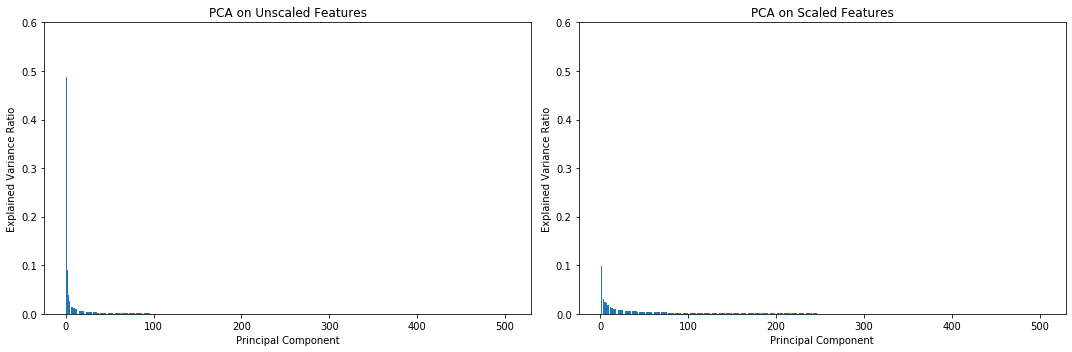

In [50]:
# Plot the explained variance ratios

plt.subplots(1, 2, figsize = (15, 5))

# Unscaled
plt.subplot(1, 2, 1)
plt.bar(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA on Unscaled Features')
plt.ylim(top = 0.6) # Equalizing the y-axes

# Scaled
plt.subplot(1, 2, 2)
plt.bar(np.arange(1, len(pca_scaled.explained_variance_ratio_)+1), pca_scaled.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA on Scaled Features')
plt.ylim(top = 0.6) # Equalizing the y-axes

plt.tight_layout()
plt.show()

These are the same trends I saw previously for male emotions.

How much variance is explained by certain numbers of unscaled and scaled principal components? This will help me determine how many principal components to try in my grid searches later.

In [51]:
# Unscaled
num_components = [503, 451, 401, 351, 301, 251, 201, 151, 101, 51]
for n in num_components:
    print(f'Variance explained by {n-1} unscaled principal components: {np.round(np.sum(pca.explained_variance_ratio_[:n])*100, 2)}%')

Variance explained by 502 unscaled principal components: 100.0%
Variance explained by 450 unscaled principal components: 99.91%
Variance explained by 400 unscaled principal components: 99.76%
Variance explained by 350 unscaled principal components: 99.53%
Variance explained by 300 unscaled principal components: 99.18%
Variance explained by 250 unscaled principal components: 98.67%
Variance explained by 200 unscaled principal components: 97.88%
Variance explained by 150 unscaled principal components: 96.65%
Variance explained by 100 unscaled principal components: 94.51%
Variance explained by 50 unscaled principal components: 89.88%


In [52]:
# Scaled
num_components = [503, 451, 401, 351, 301, 251, 201, 151, 101, 51]
for n in num_components:
    print(f'Variance explained by {n-1} scaled principal components: {np.round(np.sum(pca_scaled.explained_variance_ratio_[:n])*100, 2)}%')

Variance explained by 502 scaled principal components: 100.0%
Variance explained by 450 scaled principal components: 99.5%
Variance explained by 400 scaled principal components: 98.7%
Variance explained by 350 scaled principal components: 97.5%
Variance explained by 300 scaled principal components: 95.77%
Variance explained by 250 scaled principal components: 93.28%
Variance explained by 200 scaled principal components: 89.72%
Variance explained by 150 scaled principal components: 84.54%
Variance explained by 100 scaled principal components: 76.58%
Variance explained by 50 scaled principal components: 62.87%


Like before, I will now do a grid search for each classifier type, with five-fold cross-validation to optimize the hyperparameters.

In [53]:
# Cache
cachedir = mkdtemp()

# Pipeline (these values are placeholders)
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

In [54]:
# Parameter grid for log reg
logreg_param_grid = [
    # l1 without PCA
    # unscaled and scaled * 9 regularization strengths = 18 models
    {'scaler': [None, StandardScaler()], 'dim_reducer': [None], 'model': [LogisticRegression(penalty='l1', n_jobs=-1)],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l1 unscaled with PCA
    # 6 PCAs * 9 regularization strengths = 54 models
    {'scaler': [None], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(50, 301, 50),
     'model': [LogisticRegression(penalty='l1', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l1 scaled with PCA
    # 4 PCAs * 9 regularization strengths = 36 models
    {'scaler': [StandardScaler()], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(200, 351, 50),
     'model': [LogisticRegression(penalty='l1', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l2 (default) without PCA
    # unscaled and scaled * 9 regularization strengths = 18 models
    {'scaler': [None, StandardScaler()], 'dim_reducer': [None], 'model': [LogisticRegression(solver='lbfgs', n_jobs=-1)],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l2 (default) unscaled with PCA
    # 6 PCAs * 9 regularization strengths = 54 models
    {'scaler': [None], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(50, 301, 50),
     'model': [LogisticRegression(solver='lbfgs', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # l2 (default) scaled with PCA
    # 4 PCAs * 9 regularization strengths = 36 models
    {'scaler': [StandardScaler()], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(200, 351, 50),
     'model': [LogisticRegression(solver='lbfgs', n_jobs=-1)], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
]

# Instantiate the log reg grid search
logreg_grid_search = GridSearchCV(estimator=my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=5)

In [55]:
# Fit the log reg grid search
fitted_logreg_grid_ef = logreg_grid_search.fit(Xf_train, ef_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.4min finished


In [56]:
# What was the best log reg?
fitted_logreg_grid_ef.best_estimator_

Pipeline(memory='C:\\Users\\Patrick\\AppData\\Local\\Temp\\tmpvarqcjyw',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=350,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [57]:
print(f"The best log reg's accuracy on the training set: {fitted_logreg_grid_ef.score(Xf_train, ef_train)*100}%")
print(f"The best log reg's accuracy on the test set: {fitted_logreg_grid_ef.score(Xf_test, ef_test)*100}%")

The best log reg's accuracy on the training set: 100.0%
The best log reg's accuracy on the test set: 72.68518518518519%


In [62]:
# Pickling the best log reg
joblib.dump(fitted_logreg_grid_ef.best_estimator_, 'pickle4_female_emotion_logreg.pkl')

['pickle4_female_emotion_logreg.pkl']

In [58]:
# Parameter grid for SVM
svm_param_grid = [
    # unscaled and scaled * 9 regularization strengths = 18 models
    {'scaler': [None, StandardScaler()], 'dim_reducer': [None], 'model': [SVC()], 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # unscaled
    # 6 PCAs * 9 regularization strengths = 54 models
    {'scaler': [None], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(50, 301, 50), 'model': [SVC()],
     'model__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
    # scaled
    # 4 PCAs * 9 regularization strengths = 36 models
    {'scaler': [StandardScaler()], 'dim_reducer': [PCA()], 'dim_reducer__n_components': np.arange(200, 351, 50), 'model': [SVC()],
     'model__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
]

# Instantiate the SVM grid search
svm_grid_search = GridSearchCV(estimator=my_pipeline, param_grid=svm_param_grid, cv=5, n_jobs=-1, verbose=5)

In [59]:
# Fit the SVM grid search
fitted_svm_grid_ef = svm_grid_search.fit(Xf_train, ef_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.3min finished


In [60]:
# What was the best SVM?
fitted_svm_grid_ef.best_estimator_

Pipeline(memory='C:\\Users\\Patrick\\AppData\\Local\\Temp\\tmpvarqcjyw',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer', None),
                ('model',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [61]:
print(f"The best SVM's accuracy on the training set: {fitted_svm_grid_ef.score(Xf_train, ef_train)*100}%")
print(f"The best SVM's accuracy on the test set: {fitted_svm_grid_ef.score(Xf_test, ef_test)*100}%")

The best SVM's accuracy on the training set: 100.0%
The best SVM's accuracy on the test set: 74.07407407407408%


In [63]:
# Pickling the best SVM
joblib.dump(fitted_svm_grid_ef.best_estimator_, 'pickle5_female_emotion_svm.pkl')

['pickle5_female_emotion_svm.pkl']

Like before, I will try loading in the pickled models and evaluate them using confusion matrices and classification reports.

In [40]:
# Loading in the best female emotion classifiers
female_emotion_logreg = joblib.load('pickle4_female_emotion_logreg.pkl')
female_emotion_svm = joblib.load('pickle5_female_emotion_svm.pkl')

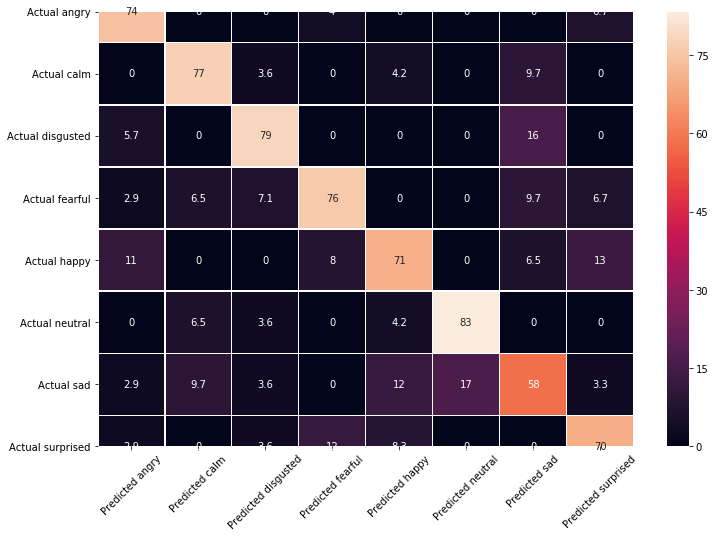

In [45]:
ef_pred = female_emotion_logreg.predict(Xf_test)

# Building the confusion matrix as a dataframe
emotions = ['angry', 'calm', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
confusion_df = pd.DataFrame(confusion_matrix(ef_test, ef_pred))
confusion_df.columns = [f'Predicted {emotion}' for emotion in emotions]
confusion_df.index = [f'Actual {emotion}' for emotion in emotions]

# Converting the above to precision scores
confusion_df_pct = round(confusion_df/confusion_df.sum(axis = 0)*100, 2)

# Heatmap of precision scores
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df_pct, annot=True, linewidths=0.5)
plt.xticks(rotation=45)
plt.show()

In [46]:
# Classification report
print(classification_report(ef_test, ef_pred))

              precision    recall  f1-score   support

       angry       0.74      0.90      0.81        29
        calm       0.77      0.83      0.80        29
   disgusted       0.79      0.76      0.77        29
     fearful       0.76      0.66      0.70        29
       happy       0.71      0.59      0.64        29
     neutral       0.83      0.71      0.77        14
         sad       0.58      0.62      0.60        29
   surprised       0.70      0.75      0.72        28

    accuracy                           0.73       216
   macro avg       0.74      0.73      0.73       216
weighted avg       0.73      0.73      0.73       216



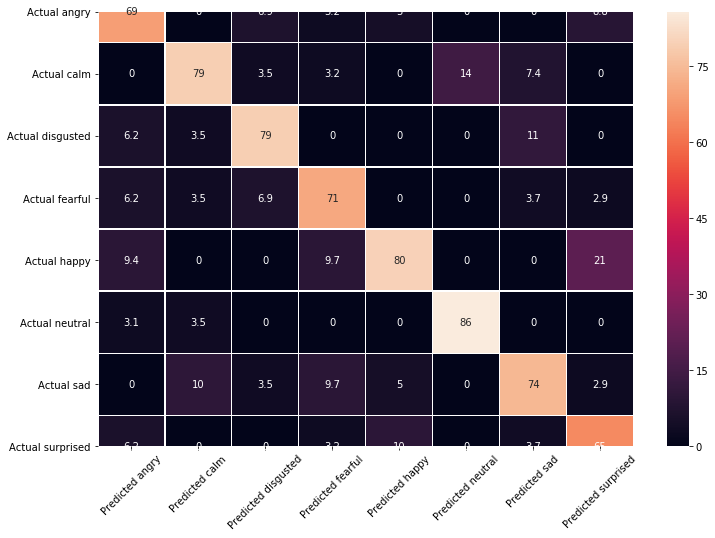

In [47]:
ef_pred = female_emotion_svm.predict(Xf_test)

# Building the confusion matrix as a dataframe
emotions = ['angry', 'calm', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
confusion_df = pd.DataFrame(confusion_matrix(ef_test, ef_pred))
confusion_df.columns = [f'Predicted {emotion}' for emotion in emotions]
confusion_df.index = [f'Actual {emotion}' for emotion in emotions]

# Converting the above to precision scores
confusion_df_pct = round(confusion_df/confusion_df.sum(axis = 0)*100, 2)

# Heatmap of precision scores
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df_pct, annot=True, linewidths=0.5)
plt.xticks(rotation=45)
plt.show()

In [48]:
# Classification report
print(classification_report(ef_test, ef_pred))

              precision    recall  f1-score   support

       angry       0.69      0.76      0.72        29
        calm       0.79      0.79      0.79        29
   disgusted       0.79      0.79      0.79        29
     fearful       0.71      0.76      0.73        29
       happy       0.80      0.55      0.65        29
     neutral       0.86      0.86      0.86        14
         sad       0.74      0.69      0.71        29
   surprised       0.65      0.79      0.71        28

    accuracy                           0.74       216
   macro avg       0.75      0.75      0.75       216
weighted avg       0.75      0.74      0.74       216

